In [3]:
%matplotlib inline

In [255]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [256]:
import numpy as np
import pandas as pd

In [257]:
import datetime

In [258]:
from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [259]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [260]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [261]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [262]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [263]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [264]:
# Create our session (link) from Python to the DB
session = Session(engine)
first_measurement = session.query(Measurement).first()
first_measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2828cc92348>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0}

In [265]:
first_station = session.query(Station).first()
first_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2828cbe5a48>,
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

# Exploratory Climate Analysis

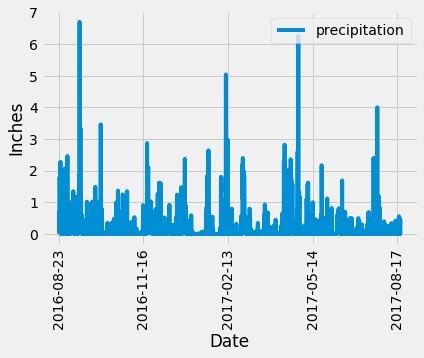

In [266]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
dates = session.query(Measurement).all()
# Last poitn in data
# dates[-1]
# Perform a query to retrieve the data and precipitation scores
one_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>= '2016-08-23',Measurement.date <= '2017-08-23').all()
# Save the query results as a Pandas DataFrame and set the index to the date column
one_year_frame = pd.DataFrame(one_year)
one_year_frame = one_year_frame.dropna()
one_year_frame = one_year_frame.rename(columns={'prcp':'precipitation'})
# Sort the dataframe by date
one_year_frame = one_year_frame.sort_values('date')
one_year_frame = one_year_frame.set_index('date',drop=True)
# Use Pandas Plotting with Matplotlib to plot the data
one_year_frame.plot(rot=90)
plt.ylabel('Inches')
plt.xlabel('Date')
plt.legend(loc='upper right')

In [267]:
# Use Pandas to calcualte the summary statistics for the precipitation data
one_year_frame.precipitation.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

In [268]:
# Design a query to show how many stations are available in this dataset?
from sqlalchemy import func
stations = session.query(func.count(func.distinct(Measurement.station))).all()
stations

[(9)]

In [269]:
session.query(Measurement.station).group_by(Measurement.station).all()

[('USC00511918'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00516128'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519281'),
 ('USC00519397'),
 ('USC00519523')]

In [270]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
count_per_station = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station)\
.order_by(func.count(Measurement.id).desc()).all()
count_per_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [271]:
for record in session.query(Station).all():
    print(record.__dict__)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000002828CBE5A48>, 'latitude': 21.2716, 'id': 1, 'elevation': 3.0, 'station': 'USC00519397', 'longitude': -157.8168, 'name': 'WAIKIKI 717.2, HI US'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000028285F855C8>, 'latitude': 21.4234, 'id': 2, 'elevation': 14.6, 'station': 'USC00513117', 'longitude': -157.8015, 'name': 'KANEOHE 838.1, HI US'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000028285F85348>, 'latitude': 21.5213, 'id': 3, 'elevation': 7.0, 'station': 'USC00514830', 'longitude': -157.8374, 'name': 'KUALOA RANCH HEADQUARTERS 886.9, HI US'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000028285F85408>, 'latitude': 21.3934, 'id': 4, 'elevation': 11.9, 'station': 'USC00517948', 'longitude': -157.9751, 'name': 'PEARL CITY, HI US'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000028285F857C8>, 'latitude': 2

In [272]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
low_high_avg_temperature = session.query(func.min(Measurement.tobs) , func.max(Measurement.tobs),\
                                   func.avg(Measurement.tobs)).filter(Measurement.station ==\
                                                                      count_per_station[0][0]).all()
low_high_avg_temperature

[(54.0, 85.0, 71.66378066378067)]

In [273]:
# Choose the station with the highest number of temperature observations.
dates_ht = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == count_per_station[0][0]).all()
dates_ht[-1]

('2017-08-18', 79.0)

In [274]:
new  = session.query(Measurement.date).order_by(Measurement.date).all()
new[0]

('2010-01-01')

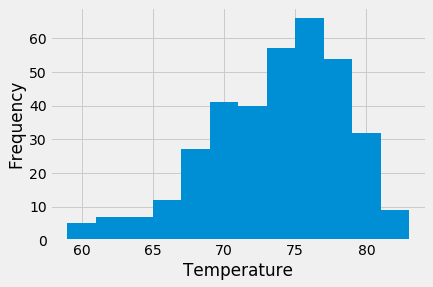

In [275]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_year_temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date<= '2017-08-18',\
                                                  Measurement.date >= '2016-08-18',\
                                                  Measurement.station == count_per_station[0][0]).all()
one_year_temp_frame = pd.DataFrame(one_year_temp)
plt.hist(one_year_temp_frame.tobs, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()
session.close()

## Bonus Challenge Assignment

In [276]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [277]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temperature_vacation = []
for i in range(8):
    item_dic = {}
    item_dic["year"] = 2010 + i
    item_dic["minimum"]= calc_temps(f"201{i}-07-01",'201{i}-07-05')[0][0]
    item_dic["average"]= calc_temps(f"201{i}-07-01",'201{i}-07-05')[0][1]
    item_dic["maximum"]= calc_temps(f"201{i}-07-01",'201{i}-07-05')[0][2]
    temperature_vacation.append(item_dic)
frame = pd.DataFrame(temperature_vacation)
frame = frame.set_index(frame.year, drop=True)
frame

,year,minimum,average,maximum
year,,,,
2010,2010,53.0,73.230609,87.0
2011,2011,53.0,73.344185,87.0
2012,2012,53.0,73.551012,87.0
2013,2013,56.0,73.865071,87.0
2014,2014,56.0,74.218914,87.0
2015,2015,56.0,74.738465,87.0
2016,2016,58.0,74.997655,87.0
2017,2017,69.0,78.592982,87.0


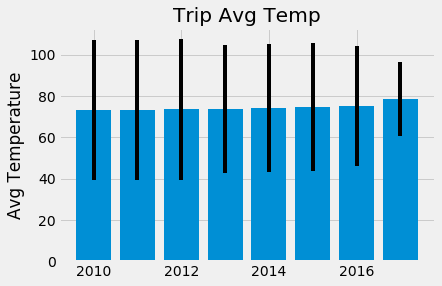

In [278]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(frame.year, frame.average, yerr=(frame.maximum-frame.minimum))
plt.ylabel("Avg Temperature")
plt.title("Trip Avg Temp")
plt.show()

In [279]:
session.query(func.sum(Measurement.prcp), Measurement.station, Station.name)\
.join(Station, Measurement.station == Station.station).group_by(Measurement.station).all()

[(92.68000000000006, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 (382.61999999999847, 'USC00513117', 'KANEOHE 838.1, HI US'),
 (234.49000000000026, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 (1068.0899999999956, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US'),
 (43.44000000000002, 'USC00517948', 'PEARL CITY, HI US'),
 (70.87000000000005, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 (588.6399999999976, 'USC00519281', 'WAIHEE 837.5, HI US'),
 (131.62000000000063, 'USC00519397', 'WAIKIKI 717.2, HI US'),
 (295.67999999999944, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US')]

In [280]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Measurement.station, Station.name, Station.latitude,\
                        Station.longitude, Station.elevation).join(Station, Measurement.station == Station.station)\
                        .group_by(Measurement.station).all()
rainfall_frame = pd.DataFrame(rainfall)
rainfall_frame["precipitation"] = ""
rainfall_frame = rainfall_frame.set_index(rainfall_frame.station, drop=True)
rainfall_frame

,station,name,latitude,longitude,elevation,precipitation
station,,,,,,
USC00511918,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,
USC00513117,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,
USC00514830,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,
USC00516128,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,
USC00517948,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,
USC00518838,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,
USC00519281,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,
USC00519397,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,
USC00519523,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,


In [281]:
# precipitation_list=[]
for index, row in rainfall_frame.iterrows():
    amount = 0
    for i in range(8):
        value = 0
        try:
            value = session.query(func.sum(Measurement.prcp)).filter(Measurement.station == f"{index}")\
            .filter(Measurement.date.between(f"201{i}-07-01",f"201{i}-07-05")).all()[0][0]
            value = float(value)
        except:
            value=0
        amount = amount + value
    rainfall_frame.loc[index, row.precipitation] = amount

rainfall_frame

,station,name,latitude,longitude,elevation,precipitation,
station,,,,,,,
USC00511918,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,,0.31
USC00513117,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,,1.83
USC00514830,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,,1.41
USC00516128,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,,11.74
USC00517948,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,,0.17
USC00518838,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,,1.25
USC00519281,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,,4.73
USC00519397,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,,0.73
USC00519523,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,,1.64


In [282]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [289]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start_trip_date = "2019-07-01"
end_trip_date = "2019-07-05"
# Use the start and end date to create a range of dates
date_list = ["07-01", "07-02", "07-03", "07-04", "07-05"]
# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
for item in date_list:
    normals.append(daily_normals(item)[0])

In [284]:
base = datetime.datetime.today()
date_list = [base - datetime.timedelta(days=x) for x in range(2)]
date_list

[datetime.datetime(2020, 5, 23, 20, 17, 50, 17878),
 datetime.datetime(2020, 5, 22, 20, 17, 50, 17878)]

In [290]:
normals[0][2]

81.0

In [303]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
fframe = pd.DataFrame()
fframe['date'] = date_list
fframe['minimum']=''
fframe['average']=''
fframe['maximum']=''

for i in range(5):
    for j in range(3):
        fframe.iloc[i,j+1] = normals[i][j]
fframe = fframe.set_index(fframe.date, drop=True)
fframe

,date,minimum,average,maximum
date,,,,
07-01,07-01,67,74.7778,81
07-02,07-02,68,75.4038,82
07-03,07-03,68,75.3208,87
07-04,07-04,70,76.5714,81
07-05,07-05,66,75,81


In [287]:
# Plot the daily normals as an area plot with `stacked=False`

<function matplotlib.pyplot.show(*args, **kw)>

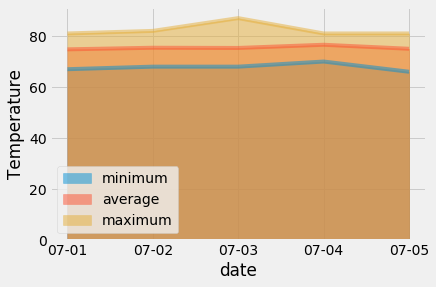

In [305]:
fframe.plot.area(stacked=False)
plt.ylabel('Temperature')
plt.show

In [306]:
session.close()